In [296]:
%matplotlib inline
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import sys

import numpy as np
import pandas as pd

import nodule
import importlib
importlib.reload(nodule)

cur_dir = os.path.abspath('.')
root_dir = os.path.dirname(cur_dir)
model_dir = os.path.join(cur_dir, "logs")
model_dir2 = os.path.join(cur_dir, "logs2")

In [297]:
class NoduleConfig(nodule.Config):
    # Give the configuration a recognizable name
    NAME = "nodule"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
#     NUM_CLASSES = 1 + 4  # background + 4 disease
    NUM_CLASSES = 1 + 3  # background + 3 disease, exclude stripe

    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 100

    # Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
    # RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels
    RPN_ANCHOR_SCALES = (4, 8, 16, 32, 64)  # anchor side in pixels

    # RPN_TRAIN_ANCHORS_PER_IMAGE = 128
    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 64

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 3

    # Max number of final detections
    DETECTION_MAX_INSTANCES = 5

    IMAGE_CHANNEL_COUNT = 1
    # Image mean
    MEAN_PIXEL = np.array([538])


class InferenceConfig(NoduleConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    
config = NoduleConfig()
inference_config = InferenceConfig()

In [298]:
class_mapper = {
    1: 'nodule',
#     5: 'stripe',
    31: 'artery',
    32: 'lymph',
}

df_record = pd.read_csv(os.path.join(cur_dir, 'annotation_voxel.csv'))

# 不训练 stripe
df_record = df_record[df_record['label'] != 5].reset_index(drop=True)

dataset_train, dataset_val = nodule.load_datasets(df_record, class_mapper=class_mapper)

In [360]:
# model_path = os.path.join(model_dir, 'nodule20190716T0813', 'mask_rcnn_nodule_0010.h5')
# model_path = os.path.join(model_dir, 'nodule20190716T1132', 'mask_rcnn_nodule_0051.h5')
# model_path = os.path.join(model_dir2, 'nodule20190716T1129', 'mask_rcnn_nodule_0090.h5')
# model_path = os.path.join(model_dir, 'nodule20190718T0127', 'mask_rcnn_nodule_0025.h5')
model_path = os.path.join(model_dir, 'nodule20190717T0055', 'mask_rcnn_nodule_0110.h5')
# model_path = os.path.join(model_dir, 'nodule20190717T0055', 'mask_rcnn_nodule_0111.h5')
# model_path = os.path.join(model_dir, 'nodule20190718T1149', 'mask_rcnn_nodule_0040.h5')

# model = nodule.load_model(inference_config, mode='training', model_path=model_path)
model = nodule.load_model(inference_config, mode='inference', model_path=model_path)

Loading weights from  /mnt/disk2/CTdata/zhuhe/logs/nodule20190717T0055/mask_rcnn_nodule_0110.h5
Re-starting from epoch 110


In [1]:
# model.train(dataset_train, dataset_val, 
#             learning_rate=config.LEARNING_RATE / 30,
#             epochs=115, 
#             layers="all")

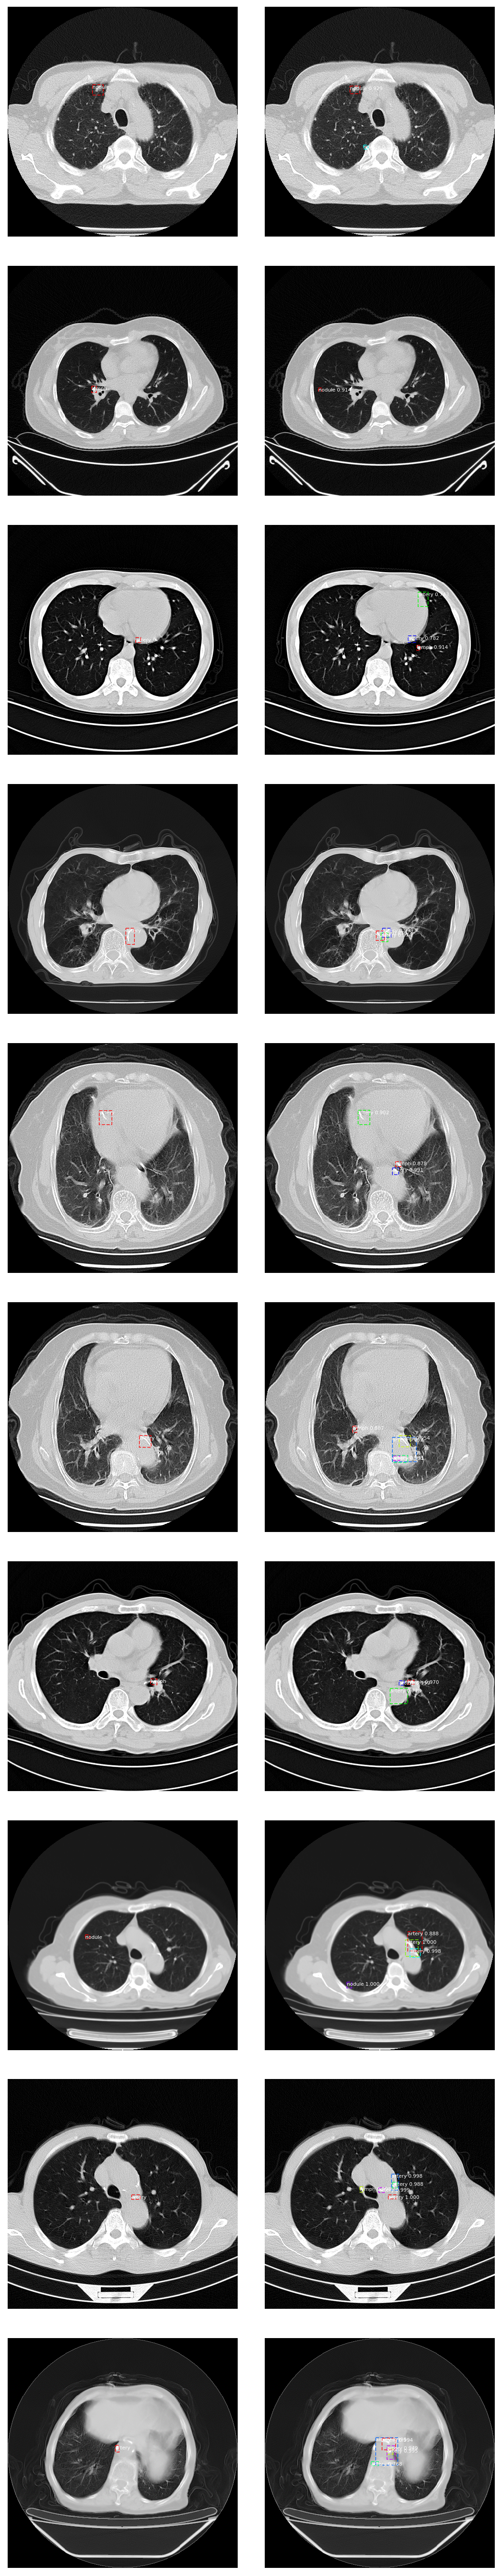

In [361]:
image_ids = range(10)
nodule.inference(model, dataset_val, image_ids, inference_config, detect_threshold=0)

In [362]:
annotation_file = '../chestCT_round1_annotation.csv'
df_gt = pd.read_csv(annotation_file, dtype={'seriesuid': int, 'label': int})

In [363]:
importlib.reload(nodule)
#seriesuid = 510918 # 318713
df_list = []
uid_list = df_gt['seriesuid'].unique()[:10]
# uid_list = [int(fn[:-4]) for fn in os.listdir('../testA/') if fn.endswith('.mhd')]
print(uid_list)
for seriesuid in uid_list:
    df_boxes = nodule.predict(model, seriesuid, datapath='train/')
    df_list.append(df_boxes)
df_boxes = pd.concat(df_list, ignore_index=True)

_mapper = dict(zip(range(1, len(class_mapper) + 1), sorted(class_mapper.keys())))
df_boxes.loc[:, 'label'] = df_boxes['label'].apply(lambda ilb: _mapper[ilb])
df_boxes.head()

[636990 696540 510918 679846 408822 655410 655458 381527 543415 647299]


,seriesuid,z,y1,x1,y2,x2,label,score
0,636990,1,273,304,286,317,31,0.875820
1,636990,1,283,236,300,250,31,0.814143
2,636990,1,251,291,272,306,31,0.754722
3,636990,2,269,254,279,274,31,0.982149
4,636990,2,272,277,282,291,31,0.927970


In [364]:
importlib.reload(nodule)
df_coord_voxel = nodule.boxes_to_3d(df_boxes[df_boxes['score'] > 0.8], iou_threashold=0.3, max_zindex_gap=1)
df_coord_voxel.head()

,seriesuid,coordX,coordY,coordZ,class,probability
0,381527,255.519976,342.315734,20.610537,31,0.921377
1,381527,271.333261,330.666623,16.000100,31,0.838430
2,381527,262.144729,346.114822,22.973810,31,0.816979
3,381527,265.045724,346.918418,16.030998,31,0.793684
4,381527,276.002193,327.752558,10.500731,31,0.669430


In [365]:
importlib.reload(nodule)
df_coord = nodule.voxel_to_world(df_coord_voxel, datapath='train/')
df_coord.head()

,seriesuid,coordX,coordY,coordZ,class,probability
0,381527,-6.317336,54.711175,-152.920970,31,0.921377
1,381527,3.708287,47.325639,-187.499246,31,0.838430
2,381527,-2.117242,57.119797,-135.196428,31,0.816979
3,381527,-0.278012,57.629277,-187.267514,31,0.793684
4,381527,6.668390,45.478122,-228.744518,31,0.669430


In [366]:
# df_save = df_coord[df_coord['probability'] > 0.25]
# df_save.to_csv('./result_hzhu212.csv', index=False)

In [367]:
importlib.reload(nodule)
froc = nodule.get_froc(df_gt, df_coord[df_coord['probability'] > 0.25])
froc

{32: (array([ 0. ,  0. ,  0.1,  0.1,  0.2,  0.2,  0.3,  0.3,  1.6,  1.6,  2. ,
          2. ,  2.4,  2.4,  2.5,  2.5,  2.7,  2.7,  3.6,  3.6, 12.4]),
  array([0.        , 0.00087719, 0.00087719, 0.00175439, 0.00175439,
         0.00263158, 0.00263158, 0.00526316, 0.00526316, 0.00614035,
         0.00614035, 0.00789474, 0.00789474, 0.00877193, 0.00877193,
         0.00964912, 0.00964912, 0.01140351, 0.01140351, 0.0122807 ,
         0.0122807 ])),
 1: (array([ 0. ,  0. ,  1.3,  1.3,  1.5,  1.5,  2.9,  2.9,  3. ,  3. ,  3.5,
          3.5,  4.5,  4.5,  5. ,  5. ,  5.1,  5.1,  5.2,  5.2,  6.5,  6.5,
         10.9, 10.9, 23.4]),
  array([0.        , 0.00030637, 0.00030637, 0.00061275, 0.00061275,
         0.00091912, 0.00091912, 0.00122549, 0.00122549, 0.00183824,
         0.00183824, 0.00214461, 0.00214461, 0.00245098, 0.00245098,
         0.00275735, 0.00275735, 0.00306373, 0.00306373, 0.0033701 ,
         0.0033701 , 0.00367647, 0.00367647, 0.00398284, 0.00398284])),
 31: (array([ 0. ,  

In [368]:
importlib.reload(nodule)
score = nodule.get_score(froc)
score

{32: 0.009971217105263157,
 1: 0.0019483379289215686,
 31: 0.0063266186622232806,
 5: 0.0}